In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

In [3]:
# Carregar a base de dados CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


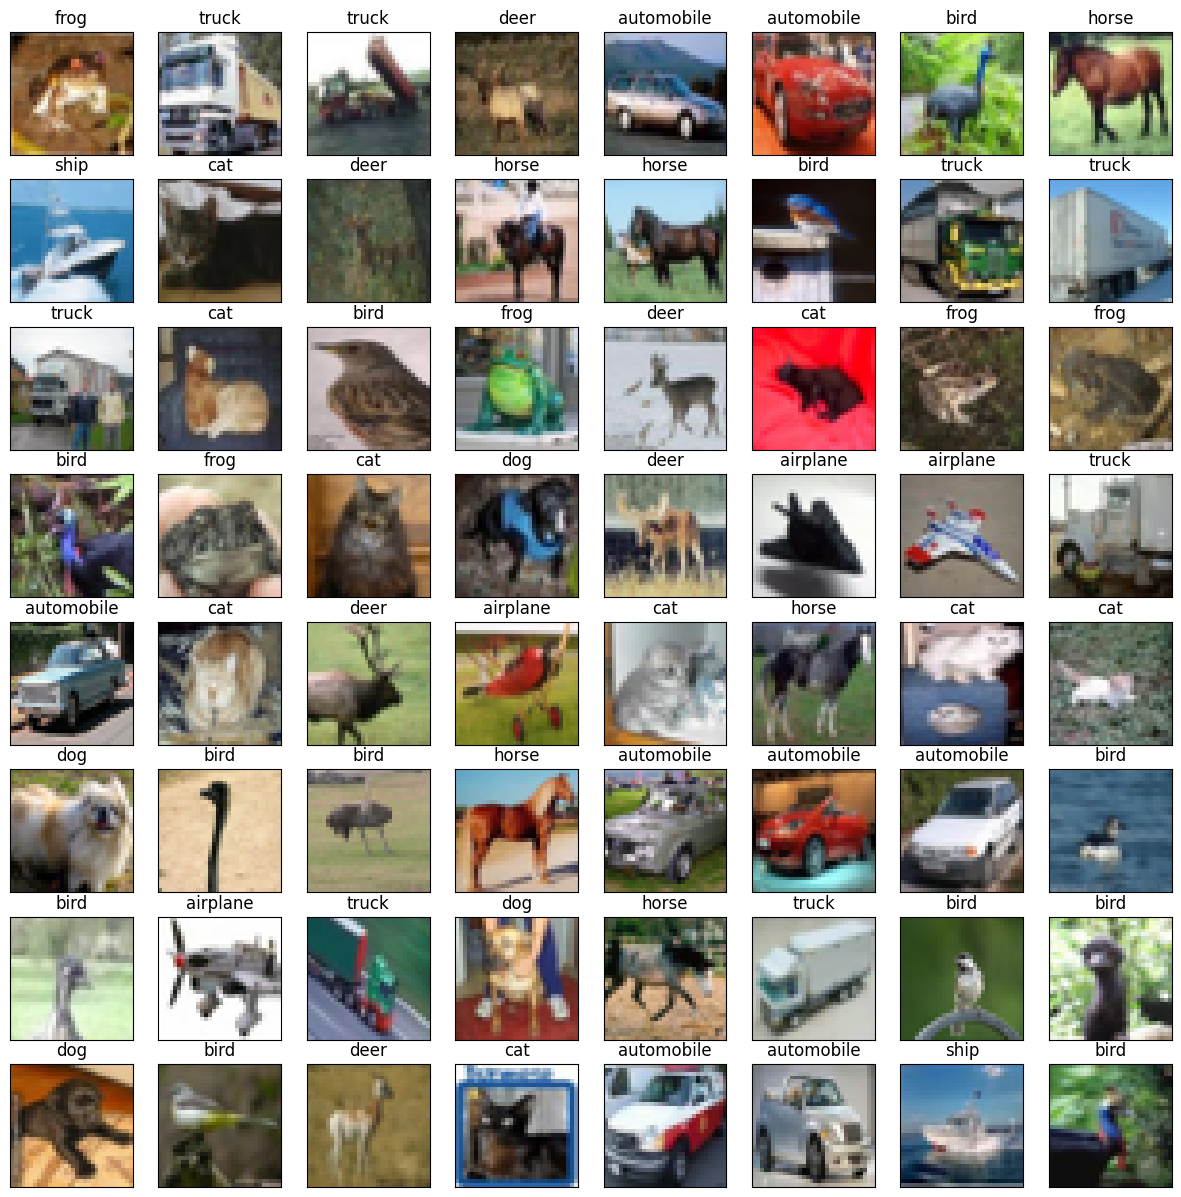

In [4]:
# Definir os nomes das classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 64 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

In [5]:
# Pré-processamento dos dados
x_train = preprocess_input(X_train)
x_test = preprocess_input(X_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
# Carregar a arquitetura do modelo VGG16 (sem incluir a camada densa superior)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
# Congelar as camadas convolucionais do modelo VGG16
for layer in vgg_model.layers:
    layer.trainable = False

In [8]:
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# Criar um modelo sequencial e adicionar as camadas do modelo VGG16 seguido de camadas densas
model = Sequential([
    vgg_model,
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compilar o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Usar o early stopping pode ajudar a evitar overfitting, parando o treinamento assim que o desempenho de validação começa a deteriorar. Também ajuda a evitar computação extra, uma vez que encerra o treinamento de o erro estiver constante.

In [15]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
# Treinar o modelo
history = model.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.4263 - loss: 2.7709 - val_accuracy: 0.6044 - val_loss: 1.1491
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.5563 - loss: 1.2976 - val_accuracy: 0.6253 - val_loss: 1.1060
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5887 - loss: 1.2095 - val_accuracy: 0.6423 - val_loss: 1.0415
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6030 - loss: 1.1666 - val_accuracy: 0.6525 - val_loss: 1.0301
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6215 - loss: 1.1324 - val_accuracy: 0.6528 - val_loss: 1.0275
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6336 - loss: 1.0865 - val_accuracy: 0.6584 - val_loss: 1.0154
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6421 - loss: 1.0753 - val_accuracy: 0.6598 - val_loss: 1.0265
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6453 - loss: 1.0570 - 

In [17]:
# Avaliar o modelo
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


Text(0.5, 1.0, 'Confusion Matrix - CIFAR-10')

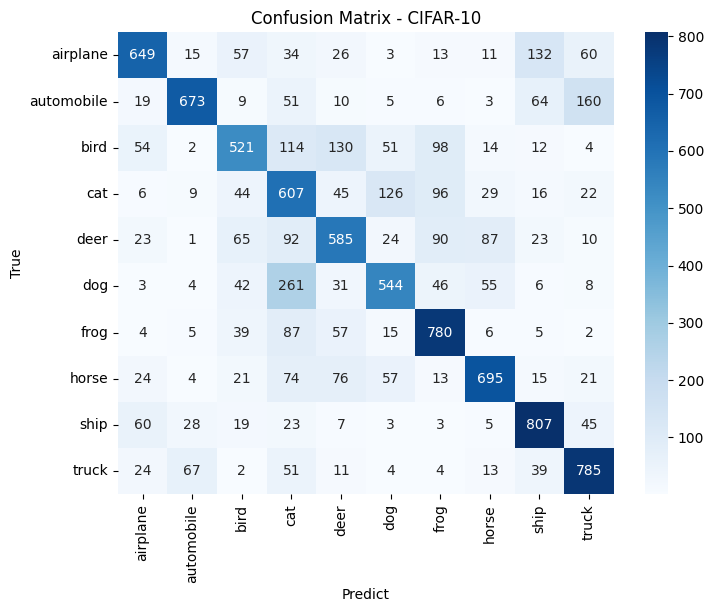

In [18]:
# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix - CIFAR-10')


Text(0.5, 1.0, 'Normalized Confusion Matrix - CIFAR-10')

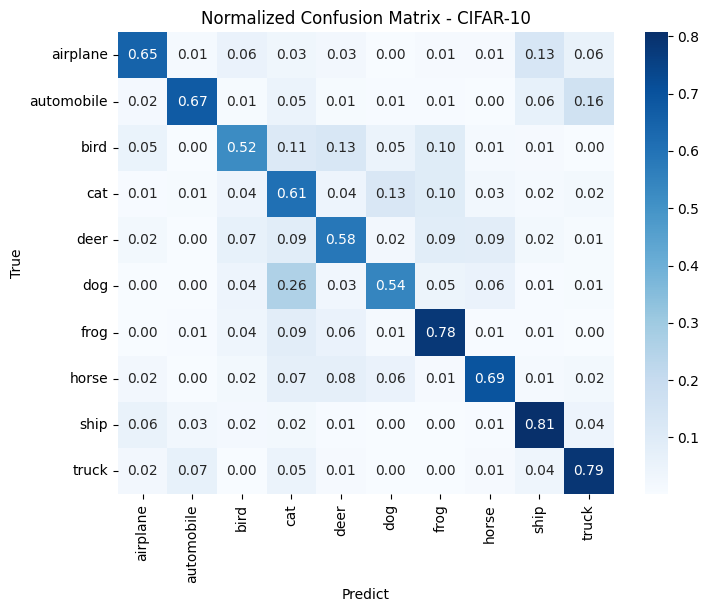

In [19]:
# Plotar a matriz de confusão normalizada
class_counts = np.sum(confusion_mtx, axis=1)
confusion_mtx_norm = confusion_mtx / class_counts[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix - CIFAR-10')

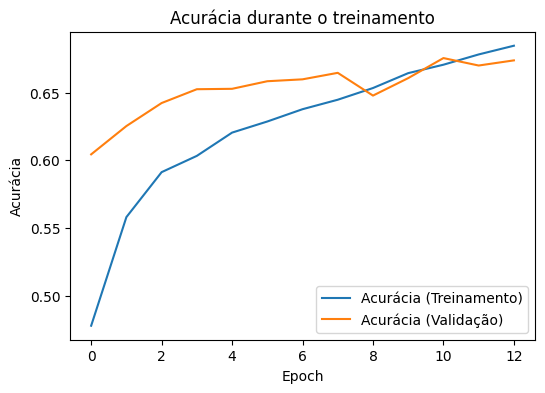

In [20]:
# Plotar gráfico de acurácia
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Acurácia (Treinamento)')
plt.plot(history.history['val_accuracy'], label='Acurácia (Validação)')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Epoch')
plt.ylabel('Acurácia')
plt.legend()

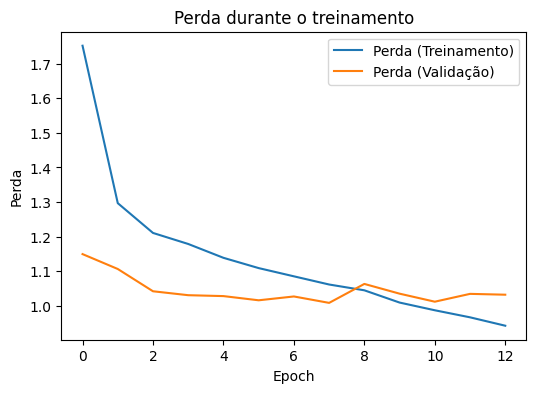

In [21]:
# Plotar gráfico de perda
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Perda (Treinamento)')
plt.plot(history.history['val_loss'], label='Perda (Validação)')
plt.title('Perda durante o treinamento')
plt.xlabel('Epoch')
plt.ylabel('Perda')
plt.legend()

plt.show()